In [ ]:
import numpy as np
import numpy as np
import numba
import matplotlib.pyplot as plt

# If you do not use Google colab, comment out the following import
from google.colab import files

#Parameters

In [ ]:
N = 3 # Single unit or 3 unit (N=3)

dt = 0.1 # ms 0.1ms is reasonable
duration = 3500  # Simulation duration (ms)
seed = 0  # seed for RNG of noise and ICs
T = duration
t = np.arange(0,T,dt)

# neural mass model parameters
tau_u = 10   # excitatory time constant
tau_p = 10   # PV time constant
tau_s = 10   # SST time constant
tau_d1 = 1500 # replenishment time constant
tau_d2 = 20   # depletion time constant
t0 = 300
dur = 100
isi = 300

w_ee = 1.1 # local E-E coupling
w_ep = 2.  # local E-PV coupling
w_es = 1.  # local E-SST coupling
w_pe = 1.  # local PV-E coupling
w_pp = 2.  # local PV-PV coupling
w_ps = 2.  # local PV-SST coupling
w_se = 6.  # local SST-E coupling
w_sp = 0.  # local SST-PV coupling
w_ss = 0.  # local SST-SST coupling

w_ee2 = 0.667 # lateral E-E coupling
w_pe2 = 1.25 # lateral PV-E coupling
w_se2 = 0.125 # lateral SST-E coupling
a = 0.5 # degree of depression
b = 2 # degree of facilitation
α = 0.65 # percentage of thalamic input
    

r_u = 3.  # excitatory gain
r_p = 3.  # PV gain
r_s = 3.  # SST gain
u_th = 0.7 # excitatory firing threshold
p_th = 1.0  # PV firing threshold
s_th = 1.0  # SST firing threshold
#q = 5/1.3 # input amplitude

opt_pv_val  = -4 # -4 default Park&Geffen # optogenetic PV suppression variable
opt_sst_val = -2 # optogenetic SST suppression variable


g = np.ones((N, len(t))) # depressing term, g = D for three unit model
F = np.zeros((N, len(t))) # facilitating term F = 1-g for three unit model

I_ext = np.zeros((N, len(t))) #Input   
I = np.zeros((N, len(t))) #Thalamic adapted input I_ext * g


# Functions for input and optogenetic stimulation

In [ ]:
def external_input(t,dt,input_time,dur):
    I_t = np.zeros(len(t))
    for i in range(len(t)):
        for j in range(len(input_time)):
            if t[i]==input_time[j] and t[i]<=input_time[j]+dur:
                I_t[i] =1
    return I_t

def thalamic_input(t, dt, input_time, dur, tau_q = 10, q = 1):
    I_t = np.zeros(len(t))
    for i in range(1,len(t)):
        I_t[i] = I_t[i-1] + (dt/tau_q) * (-I_t[i-1])
        for j in range(len(input_time)):
            if t[i]==input_time[j] and t[i]<=input_time[j]+dur:
                I_t[i] =q
    return I_t

def I_opto(t,laser_on_times,val=-1):
    I_opto = np.zeros((len(t)))
    laser_on_times = np.asarray(laser_on_times)*10
    for i in range(len(laser_on_times)):
        I_opto[laser_on_times[i][0]:laser_on_times[i][1]] = val
    return I_opto


In [ ]:
t = np.arange(0,T,dt)
I_ext = np.zeros((N, len(t))) #Input   
I = np.zeros((N, len(t))) #Thalamic adapted input I_ext * g
g = np.ones((N, len(t))) # depressing term, g = D for three unit model
F = np.zeros((N, len(t))) # facilitating term F = 1-g for three unit model
q = 5
dur = 100
input_tones = [200,600,1000,1400,1800,2200,2600,3000]
deviant_tones = [1400] # default= [1800]
standard_tones = [200,600,1000,1800,2200,2600,3000] # [200,600,1000,1400,2200,2600,3000]

I_ext[0] = thalamic_input(t, dt, deviant_tones, 100, tau_q = 10, q = 1) #Deviant
I_ext[2]= thalamic_input(t, dt, standard_tones, dur, tau_q = 10, q = 1) #Standard

# Helper functions

In [ ]:
#Rectifying 
def f(x, r):
    if x<=0:
        return 0
    elif x<=1/r:
        return r*x
    else:
        return 1
    
#Finding maximum values in firing rates
def find_max(fir_rate,input_tones,dt,interval): 
    max_values = np.zeros((len(fir_rate),len(input_tones)))
    time_adjust = int(1/dt)   
    for r in range(len(fir_rate)):
        for i in range(len(input_tones)): 
            start = int(input_tones[i]*time_adjust)
            end = int((input_tones[i] + interval)*time_adjust)
            max_values[r][i] = np.max(fir_rate[r][start:end])
        #max_values[r] = max_values[r][np.argsort(-max_values[r])]
    return max_values

#Calculating mean firing rates for the bins
def calc_mean(fir_rate,input_tones,dt,interval):
    mean_values = np.zeros((len(fir_rate),len(input_tones)))
    time_adjust = int(1/dt)   
    for r in range(len(fir_rate)):
        for i in range(len(input_tones)): 
            start = int(input_tones[i]*time_adjust)
            end = int((input_tones[i] + interval)*time_adjust)
            mean_values[r][i] = np.mean(fir_rate[r][start:end])
            #max_values[r] = max_values[r][np.argsort(-max_values[r])]
    return mean_values


# Three Unit Model

In [ ]:
def three_unit_simulation(t,dt,tau_d1,tau_d2,w_ee,w_ep,w_es,w_pe,w_pp,w_ps,w_se,w_sp,w_ss,q,I_ext,u_th,p_th,s_th,r_u,r_p,r_s,tau_u,tau_p,tau_s,Iopt_PV,Iopt_SST,opt_gen_flag=0):
    u = np.zeros((N,len(t)))
    p = np.zeros((N,len(t)))
    s = np.zeros((N,len(t)))
    g = np.ones((N,len(t)))
    F = np.zeros((N,len(t)))
    J1 = np.zeros((N,len(t)))
    J2 = np.zeros((N,len(t)))
    J3 = np.zeros((N,len(t)))
    
    for ti in range(1,len(t)): 
        for i in range(N):
            g[i,ti] = g[i,ti-1] + dt* (((1-g[i,ti-1])/tau_d1)-((g[i,ti-1] * I_ext[i,ti-1])/tau_d2))
            F[i,ti] = F[i,ti-1] + dt * (((- F[i,ti-1]) / tau_d1)+((I_ext[i,ti-1]) / tau_d2))
        
            if i == 0 or i ==2:
                I[i][ti-1]  = g[i][ti-1]*I_ext[i][ti-1] + (α * g[1][ti-1]*I_ext[1][ti-1])
                J1[i][ti-1] = -F[i][ti-1]*s[1][ti-1] + q*I[i][ti-1]+w_ee2*u[1][ti-1]
                J2[i][ti-1] = q*I[i][ti-1] +w_pe2*u[1][ti-1]
                J3[i][ti-1] = w_se2*u[1][ti-1]
            elif i ==1:
                I[1][ti-1]  = g[1][ti-1]*I_ext[i][ti-1] + (α *(g[0][ti-1]*I_ext[0][ti-1] + g[2][ti-1]*I_ext[2][ti-1]))
                J1[1][ti-1] = -F[1][ti-1]*(s[0][ti-1]+s[2][ti-1]) + q*I[1][ti-1]+(w_ee2*(u[0][ti-1]+u[2][ti-1])*(0.5))
                J2[1][ti-1] =  q*I[1][ti-1] + (w_pe2*(u[0][ti-1]+u[2][ti-1])*(0.5))
                J3[1][ti-1] =  (w_se2*(u[0][ti-1]+u[2][ti-1])*(0.5))
                
            u[i][ti] = u[i][ti-1] + (dt/tau_u) * (-u[i][ti-1] + f(w_ee * u[i][ti-1] -(w_ep-a *(1-g[i][ti-1]))*p[i][ti-1] -w_es*s[i][ti-1] +J1[i][ti-1]-u_th,r_u))
            p[i][ti] = p[i][ti-1] + (dt/tau_p) * (-p[i][ti-1] + f(w_pe * u[i][ti-1] -w_pp*p[i][ti-1] -w_ps*s[i][ti-1] + Iopt_PV[ti-1] + J2[i][ti-1]-p_th,r_p))
            s[i][ti] = s[i][ti-1] + (dt/tau_s) * (-s[i][ti-1] + f(w_se * u[i][ti-1] -w_sp*p[i][ti-1] -w_ss*s[i][ti-1] + Iopt_SST[ti-1] + J3[i][ti-1]-s_th,r_s))
    return g,u,p,s   

# Optogenetic Input

In [ ]:
laser_on_times =[]
for i in range(len(input_tones)):
    laser_on_times.append([input_tones[i]-100,input_tones[i]+50])

 

# Simulations

In [ ]:
#Control
opt_pv = np.zeros((len(t)))
opt_sst = np.zeros((len(t)))
control_g,control_u,control_p,control_s = three_unit_simulation(t,dt,tau_d1,tau_d2,w_ee,w_ep,w_es,w_pe,w_pp,w_ps,w_se,w_sp,w_ss,q,I_ext,u_th,p_th,s_th,r_u,r_p,r_s,tau_u,tau_p,tau_s,opt_pv,opt_sst,opt_gen_flag=0)

#PV Off
opt_pv = I_opto(t,laser_on_times,val=opt_pv_val)
opt_sst = np.zeros((len(t)))
opt_gen_flag = 1
pv_g,pv_u,pv_p,pv_s = three_unit_simulation(t,dt,tau_d1,tau_d2,w_ee,w_ep,w_es,w_pe,w_pp,w_ps,w_se,w_sp,w_ss,q,I_ext,u_th,p_th,s_th,r_u,r_p,r_s,tau_u,tau_p,tau_s,opt_pv,opt_sst,opt_gen_flag)

#SST Off
opt_pv = np.zeros((len(t)))
opt_sst = I_opto(t,laser_on_times,val=opt_sst_val)
opt_gen_flag = 2
sst_g,sst_u,sst_p,sst_s = three_unit_simulation(t,dt,tau_d1,tau_d2,w_ee,w_ep,w_es,w_pe,w_pp,w_ps,w_se,w_sp,w_ss,q,I_ext,u_th,p_th,s_th,r_u,r_p,r_s,tau_u,tau_p,tau_s,opt_pv,opt_sst,opt_gen_flag)


# Plot Fig 4

(5,)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

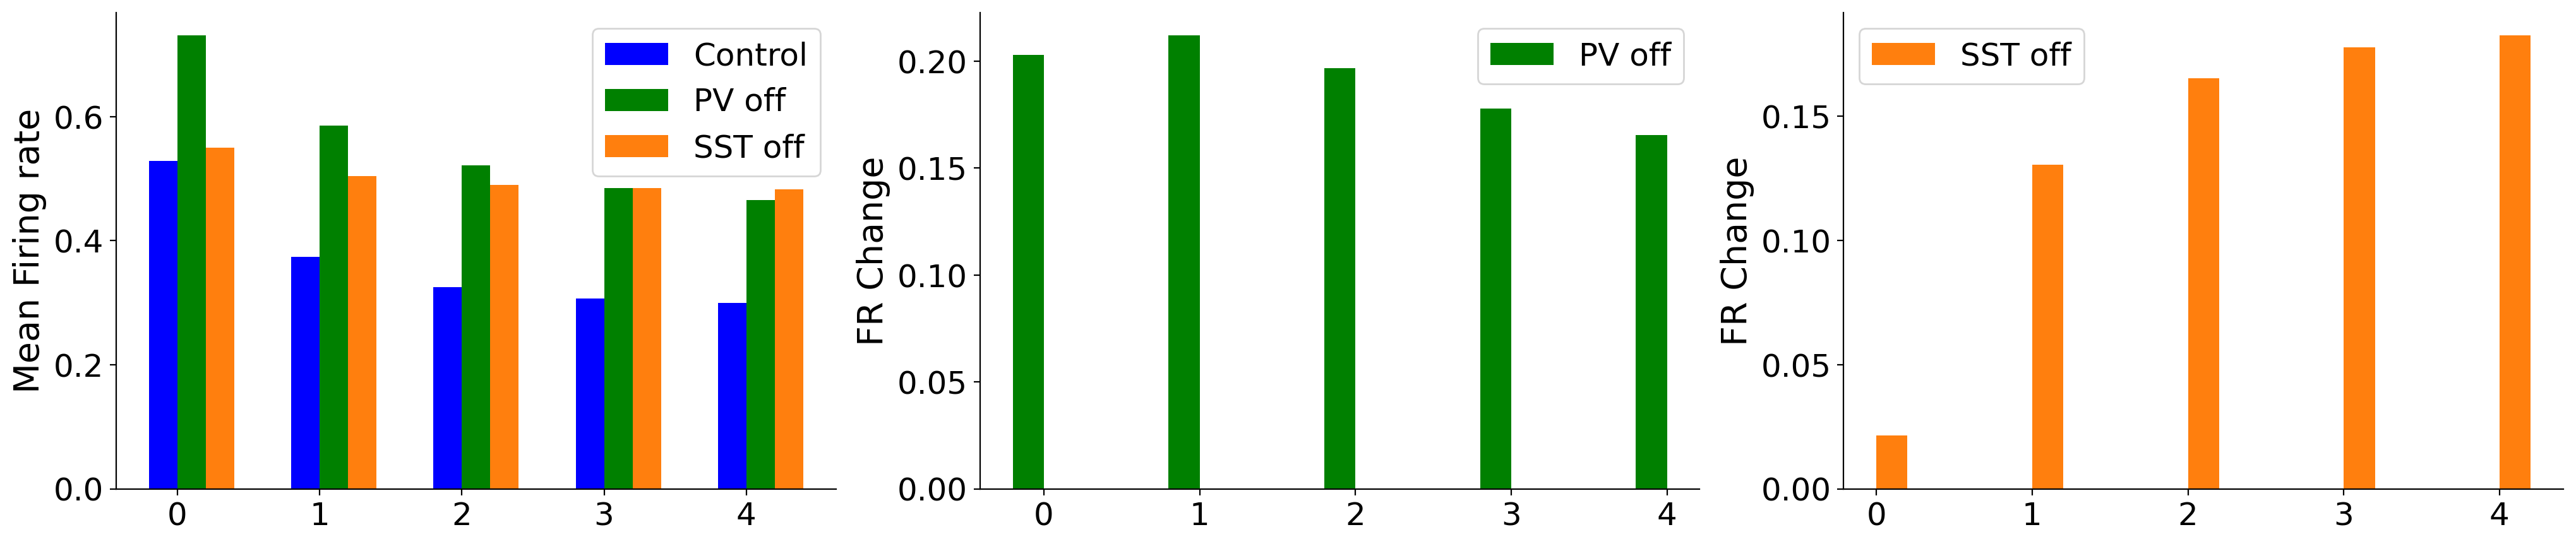

In [ ]:
max_values = find_max([control_u[1],pv_u[1],sst_u[1]],input_tones,dt,200)
#mean_values = calc_mean([control_u[1],pv_u[1],sst_u[1]],input_tones,dt,50)
labels = ['0', '1', '2', '3', '4'] #['tone1', 'tone2', 'tone3', 'tone4', 'tone5', 'tone6', 'tone7', 'tone8']
control = max_values[0][3:] #mean_values[0] # max_values[0]
pv_off = max_values[1][3:] # mean_values[1] # max_values[1]
sst_off = max_values[2][3:] # mean_values[2] # max_values[2]
print(control.shape)
x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(1,3,figsize=(25,5),dpi=200)
c1 = ax[0].bar(x - width/2, control, width, label='Control',color="blue")
p1 = ax[0].bar(x + (width/2), pv_off, width, label='PV off',color="green")
s1 = ax[0].bar(x + 3*(width/2), sst_off, width, label='SST off',color='C1')
ax[0].set_ylabel('Mean Firing rate',fontsize=20)
ax[0].set_xticks(x)
ax[0].set_xticklabels(labels)
ax[0].tick_params(axis='both', which='major', labelsize=18)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False) 
ax[0].legend(fontsize=18)

diff_p = ax[1].bar(x - (width/2), pv_off-control, width, label='PV off',color="green")
ax[1].set_ylabel('FR Change',fontsize=20)
ax[1].set_xticks(x)
ax[1].set_xticklabels(labels)
ax[1].tick_params(axis='both', which='major', labelsize=18)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False) 
ax[1].legend(fontsize=18)

diff_s = ax[2].bar(x + (width/2), sst_off-control, width, label='SST off',color='C1')
ax[2].set_ylabel('FR Change',fontsize=20)
ax[2].set_xticks(x)
ax[2].set_xticklabels(labels)
ax[2].tick_params(axis='both', which='major', labelsize=18)
ax[2].spines['top'].set_visible(False)
ax[2].spines['right'].set_visible(False) 
ax[2].legend(fontsize=18)

# If you do not use Google colab, comment out the following two lines and 
# add a line to save the plot
plt.savefig('Fig4-BDE.png', dpi=100,bbox_inches = "tight")
files.download('Fig4-BDE.png')

plt.show()

# Prediction PV On + SST On

In [ ]:
# Prediction - PV On and SST On
    
#Control
opt_pv = np.zeros((len(t)))
opt_sst = np.zeros((len(t)))
control_g,control_u,control_p,control_s = three_unit_simulation(t,dt,tau_d1,tau_d2,w_ee,w_ep,w_es,w_pe,w_pp,w_ps,w_se,w_sp,w_ss,q,I_ext,u_th,p_th,s_th,r_u,r_p,r_s,tau_u,tau_p,tau_s,opt_pv,opt_sst,opt_gen_flag=0)

#PV On
opt_pv = I_opto(t,laser_on_times,val=0.5)
opt_sst = np.zeros((len(t)))
opt_gen_flag = 1
pv_g,pv_u,pv_p,pv_s = three_unit_simulation(t,dt,tau_d1,tau_d2,w_ee,w_ep,w_es,w_pe,w_pp,w_ps,w_se,w_sp,w_ss,q,I_ext,u_th,p_th,s_th,r_u,r_p,r_s,tau_u,tau_p,tau_s,opt_pv,opt_sst,opt_gen_flag)

#SST On
opt_pv = np.zeros((len(t)))
opt_sst = I_opto(t,laser_on_times,val=1.2)
opt_gen_flag = 2
sst_g,sst_u,sst_p,sst_s = three_unit_simulation(t,dt,tau_d1,tau_d2,w_ee,w_ep,w_es,w_pe,w_pp,w_ps,w_se,w_sp,w_ss,q,I_ext,u_th,p_th,s_th,r_u,r_p,r_s,tau_u,tau_p,tau_s,opt_pv,opt_sst,opt_gen_flag)


(5,)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

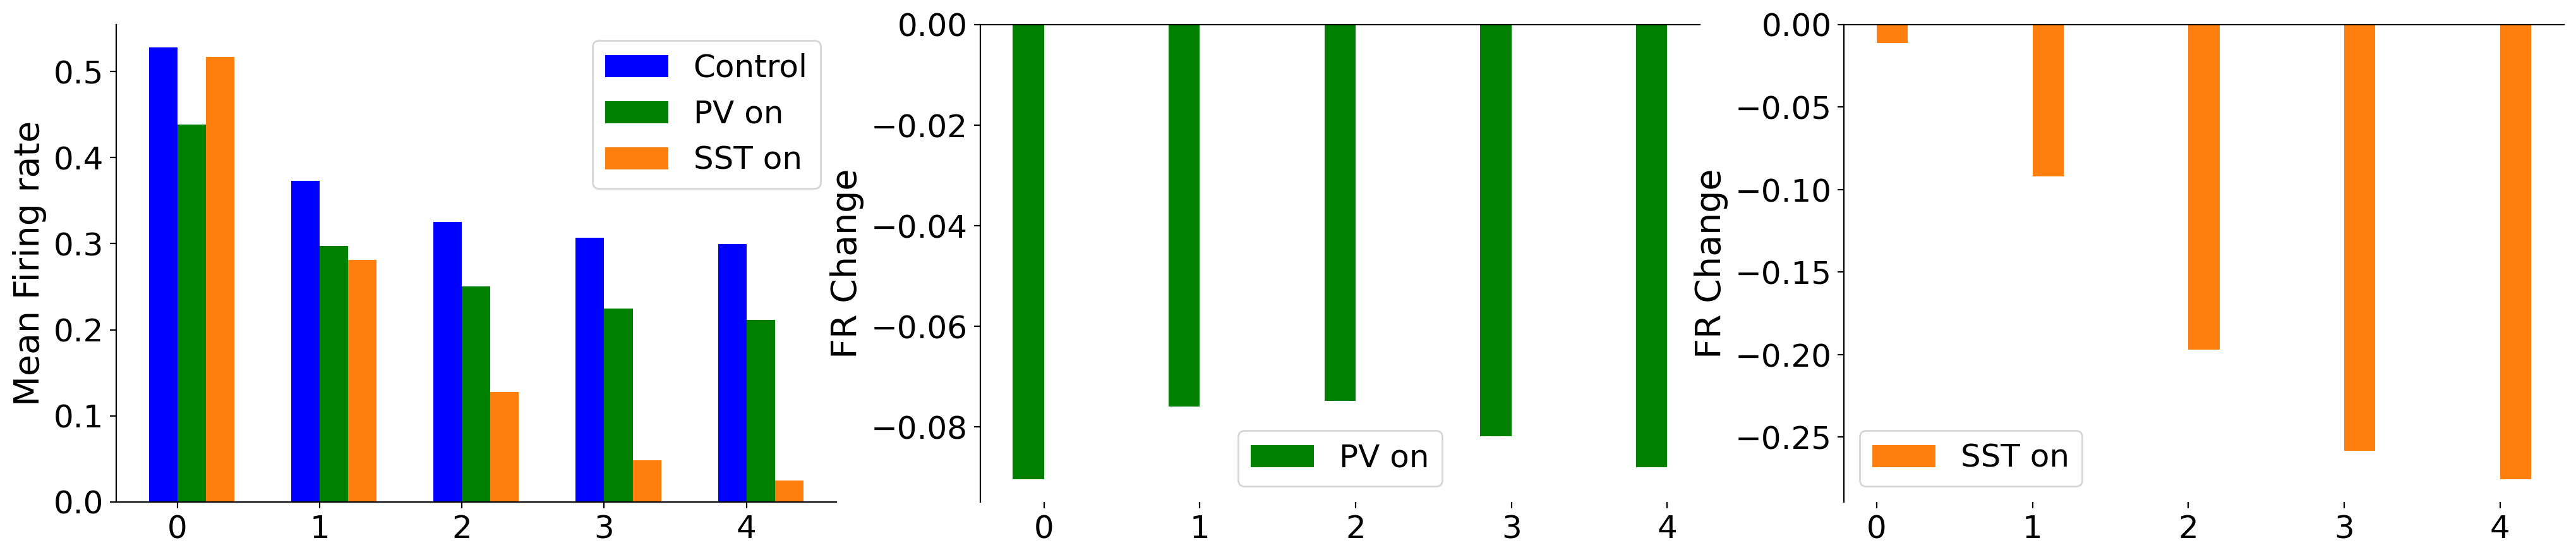

In [ ]:
max_values = find_max([control_u[1],pv_u[1],sst_u[1]],input_tones,dt,200)
labels = ['0', '1', '2', '3', '4'] #['tone1', 'tone2', 'tone3', 'tone4', 'tone5', 'tone6', 'tone7', 'tone8']
control = max_values[0][3:]
pv_on = max_values[1][3:]
sst_on = max_values[2][3:]
print(control.shape)
x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(1,3,figsize=(25,5),dpi=200)
c1 = ax[0].bar(x - width/2, control, width, label='Control',color="blue")
p1 = ax[0].bar(x + (width/2), pv_on, width, label='PV on',color="green")
s1 = ax[0].bar(x + 3*(width/2), sst_on, width, label='SST on',color='C1')
ax[0].set_ylabel('Mean Firing rate',fontsize=20)
ax[0].set_xticks(x)
ax[0].set_xticklabels(labels,fontsize=18)
ax[0].tick_params(axis='both', which='major', labelsize=18)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False) 
ax[0].legend(fontsize=18)

diff_p = ax[1].bar(x - (width/2), pv_on-control, width, label='PV on',color="green")
ax[1].set_ylabel('FR Change',fontsize=20)
ax[1].set_xticks(x)
ax[1].set_xticklabels(labels,fontsize=18)
ax[1].tick_params(axis='both', which='major', labelsize=18)
ax[1].spines['bottom'].set_visible(False)
ax[1].spines['right'].set_visible(False) 
ax[1].legend(fontsize=18)

diff_s = ax[2].bar(x + (width/2), sst_on-control, width, label='SST on',color='C1')
ax[2].set_ylabel('FR Change',fontsize=20)
ax[2].set_xticks(x)
ax[2].set_xticklabels(labels,fontsize=18)
ax[2].tick_params(axis='both', which='major', labelsize=18)
ax[2].spines['bottom'].set_visible(False)
ax[2].spines['right'].set_visible(False) 
ax[2].legend(fontsize=18)

# If you do not use Google colab, comment out the following two lines and 
# add a line to save the plot
plt.savefig('Fig4-F.png', dpi=100,bbox_inches = "tight")
files.download('Fig4-F.png')

plt.show()